# Licence

Copyright (c) 2019 Marcus D. Bloice <marcus.bloice@medunigraz.at>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Patch Augmentation

Patch augmentation is a novel technique used to attempt to create more efficient decision boundaries in neural networks in order to mitigate against adversarial attacks.

**Patch Augmentation is a data-independent approach that creates new image data based on image/label pairs, where a patch from one of the two images in the pair is superimposed on to the other image, creating a new augmented sample.**

This notebook contains an implementaton of the technique, and demonstrates its application to the CIFAR-10 and CIFAR-100 datasets, comparing it to baseline accuracies. 

Portions of this code (code relating to the creation of the ResNetv1 and ResNetv2 networks) are from the Keras documentation.

Further experiments will follow and will be added to this notebook.

## Imports

A few imports are required at first:

In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.utils import Sequence

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import random 
import os

%matplotlib inline

np.random.seed(0)

Using TensorFlow backend.


## Define the PatchAugmentation Class

The `PatchAugmentation` class is a sub-class of Keras' `Sequence` class. According to the Keras documentation:

*This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.*
See <https://keras.io/utils/#sequence>

This means that Keras will ensure we are passing all image data through the network per epoch, and that this does not need to be implemented by us.

Once we have defined the class we can perform some visual verificiations that the class works as intended.

In [2]:
class PatchAugmentation(Sequence):
    def __init__(self, batch_size, x, y, probability=1.0, image_area=1024, patch_area=0.25):
        self.batch_size = batch_size
        self.x_train = x
        self.y_train = y
        self.probability = probability
        self.image_area = image_area
        self.patch_area = patch_area
        
        # Calculate various dimensions for the patch placement.
        self.dim = int(round(math.sqrt(self.image_area)))
        self.crop_area_in_pixels = self.image_area * self.patch_area
        self.crop_dim = int(round(math.sqrt(self.crop_area_in_pixels)))
        self.max_horizontal_shift = (math.sqrt(self.image_area)) - self.crop_dim
        self.max_vertical_shift = (math.sqrt(self.image_area)) - self.crop_dim
        
    def __len__(self):
        return int(np.ceil(len(self.x_train) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        
        batch_x = np.copy(self.x_train[idx * self.batch_size:(idx+1) * self.batch_size])
        batch_y = np.copy(self.y_train[idx * self.batch_size:(idx+1) * self.batch_size])
        
        for i in range(len(batch_x)):
            
            if np.random.uniform(0, 1) <= self.probability:

                r_i = np.random.randint(0, len(self.x_train))
                
                x1 = np.random.randint(0, self.dim - self.crop_dim)
                x2 = x1 + self.crop_dim
                y1 = np.random.randint(0, self.dim - self.crop_dim)
                y2 = y1 + self.crop_dim

                batch_x[i][x1:x2, y1:y2, :] = self.x_train[r_i][x1:x2, y1:y2, :]
                                
                lambda_value = self.patch_area
                batch_y[i] = (1- lambda_value) * batch_y[i] + lambda_value * self.y_train[r_i]
            
        return batch_x, batch_y

## Visual Verification of Patch Augmentation Class

### Create A Dataset

We can create a quick dataset to visually confirm the `PatchAugmentation` class functions as intended.

Sample cat, dog, and bird images are CC0 (Creative Commons Zero) licensed, sourced from: <https://www.pexels.com/> 

First, we load some sample data:

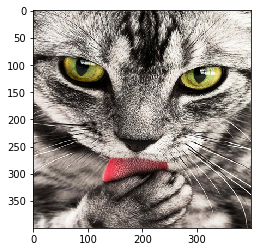

In [3]:
cat = Image.open('DemoImages/cat.jpg').resize((400,400), Image.LANCZOS)
dog = Image.open('DemoImages/dog.jpg').resize((400,400), Image.LANCZOS)
bird = Image.open('DemoImages/bird.jpg').resize((400,400), Image.LANCZOS)

cat = np.asarray(cat, dtype=np.uint16)
dog = np.asarray(dog, dtype=np.uint16)
bird = np.asarray(bird, dtype=np.uint16)
plt.imshow(cat);

We now create a a dataset with 1,000 samples based on the three images loaded above:

In [4]:
num_of_examples = 1000
x_train_exp = np.empty((num_of_examples, 400, 400, 3), dtype=np.uint16)
y_train_exp = []

for i in range(0, num_of_examples):
    
    r = random.choice([0,1,2])
    
    if r == 0:
        x_train_exp[i,:,:,:] = cat
        y_train_exp.append([1.0, 0.0, 0.0]) 
    elif r == 1:
        x_train_exp[i,:,:,:] = dog
        y_train_exp.append([0.0, 1.0, 0.0])
    else: 
        x_train_exp[i,:,:,:] = bird
        y_train_exp.append([0.0, 0.0, 1.0])

y_train_exp = np.array(y_train_exp)

# Confirm some numbers
print("Image array shape: %s, length of label vector: %s" % (x_train_exp.shape, len(y_train_exp)))

cat_count, dog_count, bird_count = 0, 0, 0
for i in range(0, len(y_train_exp)):
    if np.argmax(y_train_exp[i]) == 0:
        cat_count += 1
    elif np.argmax(y_train_exp[i]) == 1:
        dog_count += 1
    else:
        bird_count += 1

print("Number of cats: %s, number of dogs: %s, number of birds: %s." % (cat_count, dog_count, bird_count))
assert (cat_count + dog_count + bird_count) == num_of_examples

Image array shape: (1000, 400, 400, 3), length of label vector: 1000
Number of cats: 365, number of dogs: 307, number of birds: 328.


We have created a dataset containing 1,000 images and 1,000 labels, with three classes.

We can now choose a random example from the dataset and confirm it is correctly labelled.

Note that the labels for the three classes are as follows:

```
Cat  = [1. 0. 0.]
Dog  = [0. 1. 0.]
Bird = [0. 0. 1.]
```

Random index: 684
Label vector: [1. 0. 0.]


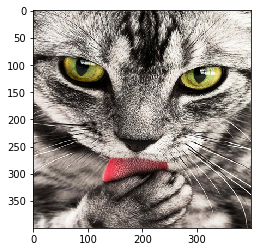

In [5]:
idx = np.random.randint(0, len(x_train_exp))
print("Random index: %s" % idx)
plt.imshow(x_train_exp[idx])
print("Label vector: %s" % y_train_exp[idx])

The label vector should match with the class labels printed above for the class cat, dog, or bird.

### Create Augmented Dataset

Now we use the `PatchAugmentation` class to generate an augmented data set using the Patch Augmentation technique.

As mentioned previously, the `PatchAugmentation` class is a subclass of Keras' `Sequence`, hence we will create a generator to view some of the data created by it:

In [6]:
b_size = 100
m = PatchAugmentation(b_size, x=x_train_exp, y=y_train_exp, probability=1.0, image_area=400*400, patch_area=0.25)

Get the generator to produce a batch of augmented samples (this will be equal to `b_size` defined above):

In [7]:
r_g = np.random.randint(0, len(m))
x, y = m.__getitem__(r_g)
print("Random batch index %s" % (r_g))

Random batch index 5


Let's look at some random images returned by the patch generator, which should contain augmented images and labels. Remeber the original one-hot-encoded labels are as follows:

```
Cat  = [1. 0. 0.]
Dog  = [0. 1. 0.]
Bird = [0. 0. 1.]
```

Index: 24, Batch: 5, Label vector: [0.   0.25 0.75]


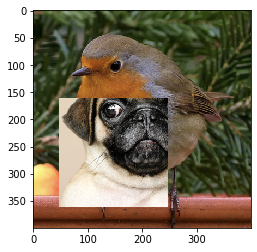

In [8]:
idex = np.random.randint(0, len(x))
print("Index: %s, Batch: %s, Label vector: %s" % (idex, r_g, y[idex]))
plt.imshow(x[idex]);

Index: 49, Batch: 5, Label vector: [0.25 0.75 0.  ]


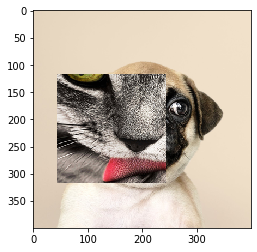

In [10]:
idex = np.random.randint(0, len(x))
print("Index: %s, Batch: %s, Label vector: %s" % (idex, r_g, y[idex]))
plt.imshow(x[idex]);

Index: 87, Batch: 5, Label vector: [0.75 0.25 0.  ]


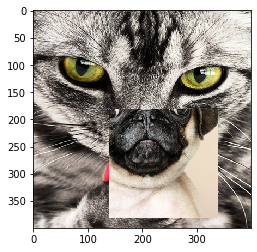

In [11]:
idex = np.random.randint(0, len(x))
print("Index: %s, Batch: %s, Label vector: %s" % (idex, r_g, y[idex]))
plt.imshow(x[idex]);

Now that we have visually confirmed the `PatchAugmentation` class we can define the networks we will use for the experiments.

## Setting Up ResNetv1 and ResNetv2

Here we define some functions for creating ResNet v1 and v2, etc.

Learning rate scheduling is used by most implementations of CIFAR, so we will also use it:

In [12]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 100, 140, 180, and 190 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 190: 
        lr *= 0.5e-3
    elif epoch > 180:  
        lr *= 1e-3
    elif epoch > 140: 
        lr *= 1e-2
    elif epoch > 100: 
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

Define a RESNET layer:

In [13]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

Now we define our ResNet networks, using the `resnet_layer()` function defined above. We start with ResNetv1:

In [14]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

Followed by ResNetv2, also using the `resnet_layer()` function defined previously:

In [15]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

Define a number of hyper-parameters:

In [16]:
# Subtracting the pixel mean helps with the final accuracy. For all experiments we leave this as True.
subtract_pixel_mean = True

# Depth of the ResNet network can be defined here.
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

Here we prepare the CIFAR10 data set using some of the parameters above defined above:

In [17]:
cifar_10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(cifar_10_labels)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

input_shape = x_train.shape[1:]

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

Now we are ready to create the network, using the parameters set above (such as ResNet version and depth):

In [18]:
# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

save_dir = os.path.join('/tmp/', 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


callbacks = [lr_reducer, lr_scheduler]  # Add checkpoint to this list to save model file

print(model_type)

Learning rate:  0.001
ResNet20v1


The type of network is printed above for confirmation.

## Train The Network

Now we have prepared a network, we can train it using a `PatchAugmentation` generator:

In [19]:
patch_swap_generator = PatchAugmentation(batch_size=128, 
                                         x=x_train, 
                                         y = y_train, 
                                         probability=0.5, 
                                         patch_area=0.25)

Then start training the network with the generator:

In [20]:
history = model.fit_generator(patch_swap_generator, 
                              epochs=200, 
                              validation_data=(x_test, y_test), 
                              shuffle=True, 
                              callbacks=callbacks, 
                              verbose=1)

Epoch 1/200
Learning rate:  0.001
391/391 [==============================] - 28s 72ms/step - loss: 1.8827 - acc: 0.4097 - val_loss: 1.6742 - val_acc: 0.4494
Epoch 2/200
Learning rate:  0.001
391/391 [==============================] - 22s 56ms/step - loss: 1.5854 - acc: 0.5378 - val_loss: 1.4122 - val_acc: 0.5586
Epoch 3/200
Learning rate:  0.001
391/391 [==============================] - 22s 57ms/step - loss: 1.4532 - acc: 0.5992 - val_loss: 1.1449 - val_acc: 0.6447
Epoch 4/200
Learning rate:  0.001
391/391 [==============================] - 22s 57ms/step - loss: 1.3550 - acc: 0.6394 - val_loss: 1.0769 - val_acc: 0.6689
Epoch 5/200
Learning rate:  0.001
391/391 [==============================] - 22s 57ms/step - loss: 1.2972 - acc: 0.6663 - val_loss: 1.1309 - val_acc: 0.6508
Epoch 6/200
Learning rate:  0.001
391/391 [==============================] - 22s 57ms/step - loss: 1.2471 - acc: 0.6859 - val_loss: 1.2726 - val_acc: 0.6051
Epoch 7/200
Learning rate:  0.001
391/391 [===============

Epoch 53/200
Learning rate:  0.001
391/391 [==============================] - 22s 57ms/step - loss: 0.8361 - acc: 0.8598 - val_loss: 0.9260 - val_acc: 0.7928
Epoch 54/200
Learning rate:  0.001
391/391 [==============================] - 23s 58ms/step - loss: 0.8380 - acc: 0.8585 - val_loss: 0.8461 - val_acc: 0.8046
Epoch 55/200
Learning rate:  0.001
391/391 [==============================] - 23s 59ms/step - loss: 0.8303 - acc: 0.8628 - val_loss: 0.8794 - val_acc: 0.7888
Epoch 56/200
Learning rate:  0.001
391/391 [==============================] - 22s 56ms/step - loss: 0.8310 - acc: 0.8603 - val_loss: 0.9165 - val_acc: 0.7756
Epoch 57/200
Learning rate:  0.001
391/391 [==============================] - 22s 56ms/step - loss: 0.8353 - acc: 0.8597 - val_loss: 0.7597 - val_acc: 0.8227
Epoch 58/200
Learning rate:  0.001
391/391 [==============================] - 22s 55ms/step - loss: 0.8304 - acc: 0.8623 - val_loss: 1.0748 - val_acc: 0.7636
Epoch 59/200
Learning rate:  0.001
391/391 [========

Epoch 105/200
Learning rate:  0.0001
391/391 [==============================] - 24s 62ms/step - loss: 0.7037 - acc: 0.9137 - val_loss: 0.6560 - val_acc: 0.8671
Epoch 106/200
Learning rate:  0.0001
391/391 [==============================] - 25s 63ms/step - loss: 0.7044 - acc: 0.9149 - val_loss: 0.6421 - val_acc: 0.8628
Epoch 107/200
Learning rate:  0.0001
391/391 [==============================] - 24s 62ms/step - loss: 0.6988 - acc: 0.9153 - val_loss: 0.6495 - val_acc: 0.8635
Epoch 108/200
Learning rate:  0.0001
391/391 [==============================] - 22s 56ms/step - loss: 0.6915 - acc: 0.9170 - val_loss: 0.6463 - val_acc: 0.8664
Epoch 109/200
Learning rate:  0.0001
391/391 [==============================] - 24s 62ms/step - loss: 0.6878 - acc: 0.9182 - val_loss: 0.6424 - val_acc: 0.8664
Epoch 110/200
Learning rate:  0.0001
391/391 [==============================] - 25s 63ms/step - loss: 0.6878 - acc: 0.9199 - val_loss: 0.6448 - val_acc: 0.8657
Epoch 111/200
Learning rate:  0.0001
391

391/391 [==============================] - 23s 58ms/step - loss: 0.6221 - acc: 0.9368 - val_loss: 0.6080 - val_acc: 0.8674
Epoch 157/200
Learning rate:  1e-05
391/391 [==============================] - 22s 56ms/step - loss: 0.6142 - acc: 0.9370 - val_loss: 0.6088 - val_acc: 0.8672
Epoch 158/200
Learning rate:  1e-05
391/391 [==============================] - 22s 56ms/step - loss: 0.6159 - acc: 0.9371 - val_loss: 0.6074 - val_acc: 0.8677
Epoch 159/200
Learning rate:  1e-05
391/391 [==============================] - 23s 58ms/step - loss: 0.6188 - acc: 0.9366 - val_loss: 0.6088 - val_acc: 0.8673
Epoch 160/200
Learning rate:  1e-05
391/391 [==============================] - 22s 56ms/step - loss: 0.6152 - acc: 0.9384 - val_loss: 0.6089 - val_acc: 0.8674
Epoch 161/200
Learning rate:  1e-05
391/391 [==============================] - 22s 55ms/step - loss: 0.6144 - acc: 0.9374 - val_loss: 0.6096 - val_acc: 0.8674
Epoch 162/200
Learning rate:  1e-05
391/391 [==============================] - 22s

Plotting the accuracy and loss:

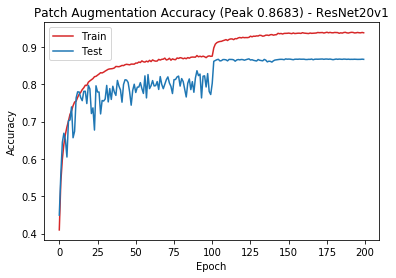

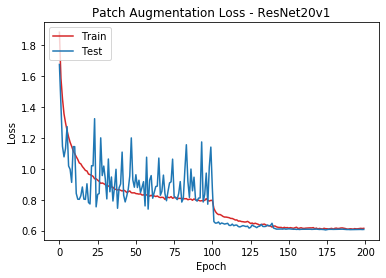

In [24]:
# Plot Accuracy
acc_peak = np.max(history.history['val_acc'])
plt.plot(history.history['acc'], color='tab:red')
plt.plot(history.history['val_acc'], color='tab:blue')
plt.title('Patch Augmentation Accuracy (Peak %s) - %s' % (acc_peak, model_type))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], color='tab:red')
plt.plot(history.history['val_loss'], color='tab:blue')
plt.title('Patch Augmentation Loss - %s' % (model_type))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Results

From a baseline accuracy of approximately 80.5%, Patch Augmentation improves accuracy to 86.8%.